## 異常検知 (Anomaly Detection)

ガウシアンモデルを使って、ネットワーク上のサーバがFailしているのを発見する

Source: http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-8/

アルゴリズムの流れ
1. 異常を検知できる特徴xiを選ぶ
2. パラメータμ、σをフィットさせる
3. 新しいサンプルxを与え、p(x)を計算する
4. p(x) < ε ければ、異常と判断する

In [1]:
# ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat
from scipy import stats

In [2]:
# データの読み込み
data = loadmat('../data/ex8data1.mat')
X = data['X']
X.shape # (307, 2) 2つの特徴がある307件のデータ

(307, 2)

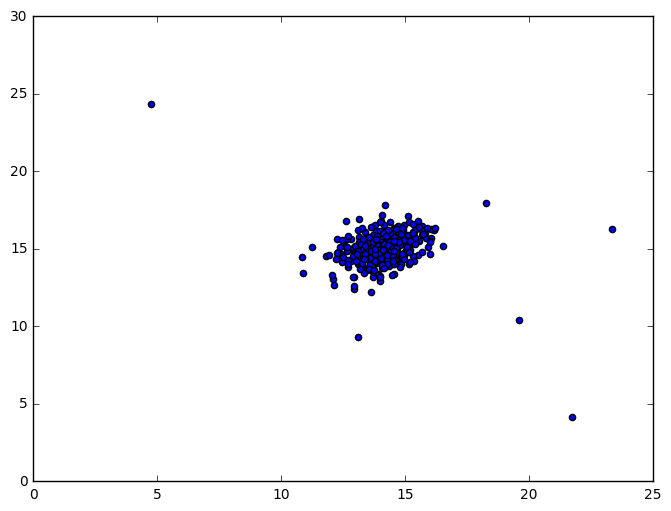

In [3]:
# プロットする
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:, 0], X[:, 1]) # １つのクラスターとなっている

In [4]:
# 平均(mu)と分散(sigma)を計算する
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    return mu, sigma

In [5]:
# モデルパラメータμ, σを取得する
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

In [6]:
# 閾値εを決めるために、ラベル付けされたバリデーションデータを使ってテスト行う
Xval = data['Xval']
yval = data['yval']
Xval.shape, yval.shape

((307, 2), (307, 1))

In [8]:
# 正規分布を計算する
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

pval = np.zeros((X.shape[0], X.shape[1]))
pval[:, 0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:, 0])
pval[:, 1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:, 1])

In [9]:
def select_threshold(pval, yval):
    """最適な閾値εを探す。F1スコアを使って検証する"""
    best_epsilon = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    f1 = 0
    step = (pval.max() - pval.min()) / 1000
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        # f1値がベストなf1よりも良い場合、ベストなεも更新
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            best_precision = precision
            best_recall = recall
    return best_epsilon, best_f1, best_precision, best_recall

In [10]:
def plot_precision_and_recall(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_title('Precision and Recall')
    step = (pval.max() - pval.min()) / 1000
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        ax.scatter(precision, recall)

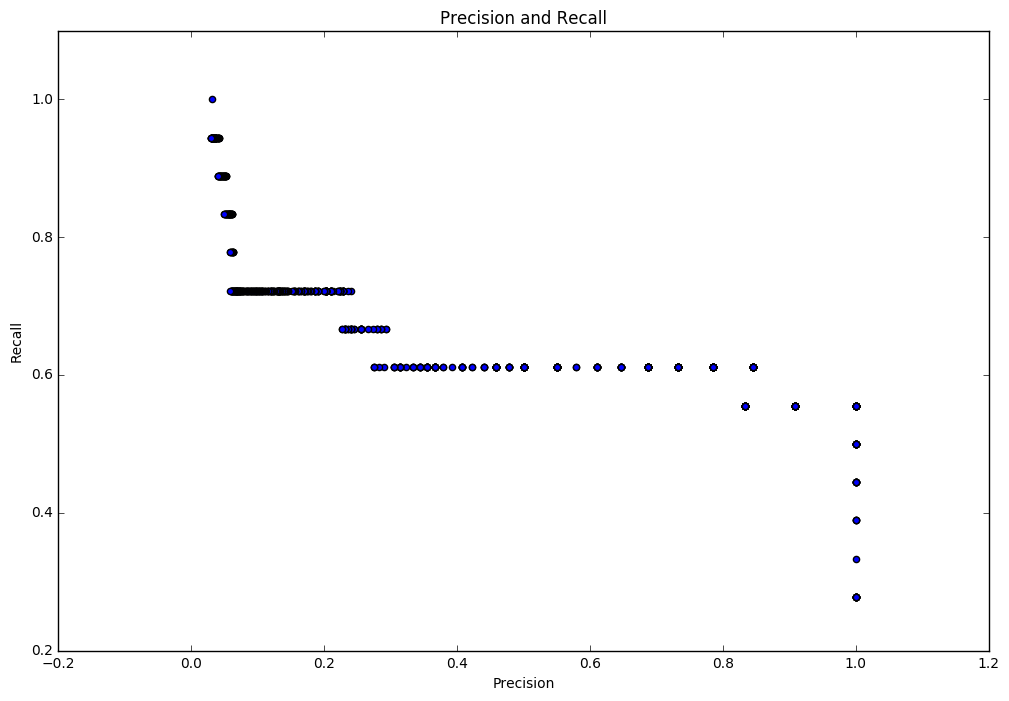

In [11]:
plot_precision_and_recall(pval, yval)

In [12]:
epsilon, f1, best_precision, best_recall = select_threshold(pval, yval)
epsilon, f1, best_precision, best_recall

(0.0095667060059568421, 0.7142857142857143, 1.0, 0.55555555555555558)

In [13]:
# εを適用する
outliers = np.where(p < epsilon)

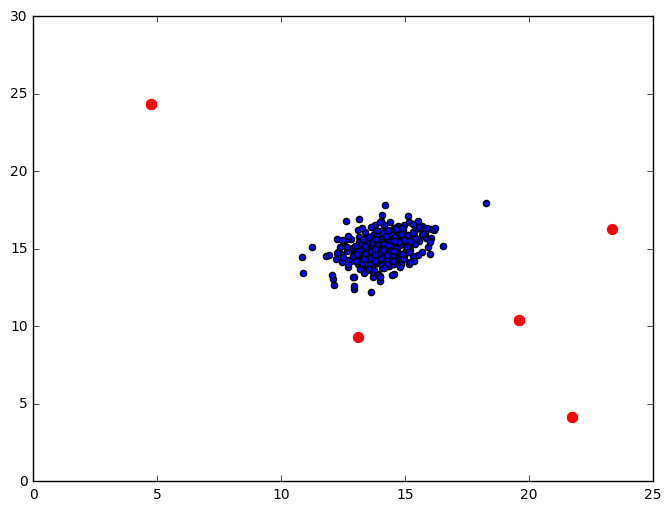

In [15]:
# 結果をプロットする
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:, 0], X[:, 1]) # １つのクラスターとなっている
ax.scatter(X[outliers[0], 0], X[outliers[0], 1], s=50, color='r', marker='o')